# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [156]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVR

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

# Data inspection

In [2]:
# load in the data
demo = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';')

/Users/jj/Documents/udacity/venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
feat_info = pd.read_excel("DIAS Attributes - Values 2017.xlsx", header = 1)

In [4]:
# seems to be the index
demo["LNR"].nunique()

891221

In [5]:
demo.shape

(891221, 366)

In [6]:
demo.AGER_TYP.value_counts()

-1    677503
 2     98472
 1     79802
 3     27104
 0      8340
Name: AGER_TYP, dtype: int64

In [7]:
demo.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [8]:
demo.tail(2)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
891219,825776,-1,9.0,0.0,17.0,NaN,NaN,NaN,20.0,7.0,...,4.0,9.0,8.0,5.0,1.0,9.0,5.0,5,1,1
891220,825787,-1,1.0,0.0,NaN,NaN,NaN,NaN,NaN,10.0,...,3.0,8.0,10.0,7.0,6.0,3.0,4.0,3,1,4


In [9]:
demo.shape

(891221, 366)

In [10]:
demo.info(verbose = True, null_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 366 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   LNR                          891221 non-null  int64  
 1   AGER_TYP                     891221 non-null  int64  
 2   AKT_DAT_KL                   817722 non-null  float64
 3   ALTER_HH                     817722 non-null  float64
 4   ALTER_KIND1                  81058 non-null   float64
 5   ALTER_KIND2                  29499 non-null   float64
 6   ALTER_KIND3                  6170 non-null    float64
 7   ALTER_KIND4                  1205 non-null    float64
 8   ALTERSKATEGORIE_FEIN         628274 non-null  float64
 9   ANZ_HAUSHALTE_AKTIV          798073 non-null  float64
 10  ANZ_HH_TITEL                 794213 non-null  float64
 11  ANZ_KINDER                   817722 non-null  float64
 12  ANZ_PERSONEN                 817722 non-null  float64
 13

In [11]:
demo.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,8.912210e+05,891221.000000,817722.000000,817722.000000,81058.000000,29499.000000,6170.000000,1205.000000,628274.000000,798073.000000,...,770025.000000,815304.000000,815304.000000,815304.000000,783619.000000,817722.000000,798073.000000,891221.000000,891221.000000,891221.000000
mean,6.372630e+05,-0.358435,4.421928,10.864126,11.745392,13.402658,14.476013,15.089627,13.700717,8.287263,...,2.417322,6.001214,7.532130,5.945972,3.933406,7.908791,4.052836,3.362438,1.522098,2.777398
std,2.572735e+05,1.198724,3.638805,7.639683,4.097660,3.243300,2.712427,2.452932,5.079849,15.628087,...,1.166572,2.856091,3.247789,2.771464,1.964701,1.923137,1.949539,1.352704,0.499512,1.068775
min,1.916530e+05,-1.000000,1.000000,0.000000,2.000000,2.000000,4.000000,7.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,4.144580e+05,-1.000000,1.000000,0.000000,8.000000,11.000000,13.000000,14.000000,11.000000,1.000000,...,2.000000,3.000000,5.000000,4.000000,2.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,6.372630e+05,-1.000000,3.000000,13.000000,12.000000,14.000000,15.000000,15.000000,14.000000,4.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,3.000000,3.000000,2.000000,3.000000
75%,8.600680e+05,-1.000000,9.000000,17.000000,15.000000,16.000000,17.000000,17.000000,17.000000,9.000000,...,3.000000,9.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000
max,1.082873e+06,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,595.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


In [12]:
customers.head(2)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4


In [13]:
customers.info(verbose = True, null_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Data columns (total 369 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   LNR                          191652 non-null  int64  
 1   AGER_TYP                     191652 non-null  int64  
 2   AKT_DAT_KL                   145056 non-null  float64
 3   ALTER_HH                     145056 non-null  float64
 4   ALTER_KIND1                  11766 non-null   float64
 5   ALTER_KIND2                  5100 non-null    float64
 6   ALTER_KIND3                  1275 non-null    float64
 7   ALTER_KIND4                  236 non-null     float64
 8   ALTERSKATEGORIE_FEIN         139810 non-null  float64
 9   ANZ_HAUSHALTE_AKTIV          141725 non-null  float64
 10  ANZ_HH_TITEL                 139542 non-null  float64
 11  ANZ_KINDER                   145056 non-null  float64
 12  ANZ_PERSONEN                 145056 non-null  float64
 13

In [14]:
customers.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,191652.000000,191652.000000,145056.000000,145056.000000,11766.000000,5100.000000,1275.000000,236.000000,139810.000000,141725.000000,...,143781.000000,143781.000000,143781.000000,137910.000000,145056.000000,141725.000000,191652.000000,191652.000000,191652.000000,191652.000000
mean,95826.500000,0.344359,1.747525,11.352009,12.337243,13.672353,14.647059,15.377119,10.331579,4.965863,...,4.374417,4.564769,3.168868,4.152716,8.646371,3.723133,2.576806,0.090247,1.376432,3.060907
std,55325.311233,1.391672,1.966334,6.275026,4.006050,3.243335,2.753787,2.307653,4.134828,14.309694,...,2.924355,2.887035,2.233516,1.974375,1.154001,2.095540,1.168486,0.286536,0.484492,1.086254
min,1.000000,-1.000000,1.000000,0.000000,2.000000,2.000000,5.000000,8.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,47913.750000,-1.000000,1.000000,8.000000,9.000000,11.000000,13.000000,14.000000,9.000000,1.000000,...,2.000000,2.000000,1.000000,2.000000,9.000000,2.000000,1.000000,0.000000,1.000000,3.000000
50%,95826.500000,0.000000,1.000000,11.000000,13.000000,14.000000,15.000000,16.000000,10.000000,1.000000,...,4.000000,4.000000,3.000000,5.000000,9.000000,3.000000,3.000000,0.000000,1.000000,3.000000
75%,143739.250000,2.000000,1.000000,16.000000,16.000000,16.000000,17.000000,17.000000,13.000000,4.000000,...,7.000000,7.000000,4.000000,6.000000,9.000000,5.000000,3.000000,0.000000,2.000000,4.000000
max,191652.000000,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,523.000000,...,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,1.000000,2.000000,9.000000


In [15]:
feat_info.head()

,Unnamed: 0,Attribute,Description,Value,Meaning
0,NaN,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,NaN,0,no classification possible
2,NaN,NaN,NaN,1,passive elderly
3,NaN,NaN,NaN,2,cultural elderly
4,NaN,NaN,NaN,3,experience-driven elderly


# Data Wrangling
## Todo:
 - [x] Convert missing values code to Nans
 - [x] Keep only rows that have the meaning unknown in feat_info
     - [x] Distill into list of attribute name and values describing unknown
 - [x] Make LNR the index

In [16]:
demo.set_index("LNR", inplace = True)
customers.set_index("LNR", inplace = True)

In [17]:
# Get only the rows that show the values for unknown
feat_info = feat_info.query("Meaning == 'unknown' or Meaning == 'missing'")
#feat_info = feat_info[feat_info["Meaning"] == 'unknown' or feat_info["Meaning"]]

In [18]:
# Drop columns that we don't need for the unknown to nan convert
feat_info.drop(columns = ["Unnamed: 0", "Description", "Meaning"], inplace = True)
# set the attribute as the index
feat_info.set_index("Attribute", inplace = True)

In [19]:
# convert to list
feat_info["Value"] = feat_info["Value"].astype(str)
# Save in a column with different name
feat_info["missing_or_unknown"] = feat_info["Value"].apply(lambda x: x.split(","))

In [20]:
# Drop original column
feat_info.drop(columns = ["Value"], inplace = True)

In [21]:
# Iterates through the columns of demografics
for column in demo.columns:
    # saves the values as a list which are nan in this colum
    try:
        null_values = feat_info.loc[str(column), "missing_or_unknown"]
    except:
        # some value coding is missing but -1 alway codes for NaN"
        null_values = ["-1"]
    for entry in null_values:
        # Some columns do not have an indicator for null values,
        try:
            if (entry != ""):
                # replaces every null value with an np.nan in the column
                demo[column] = demo[column].replace(int(entry), np.nan)
            else:
                print("Entry was an empty string: -{}- (should be empty)".format(entry))
        except:
            print("Entry {} is not a number.".format(entry))
            demo[column] = demo[column].replace(entry, np.nan)
    

In [22]:
demo.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
LNR,,,,,,,,,,,,,,,,,,,,,
910215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
910220,NaN,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,0.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
910225,NaN,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,0.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
910226,2.0,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,0.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
910241,NaN,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,0.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


## Check for missing data in columns

In [23]:
# track number of nan values for eacht column:
nan_values = []
for column in demo.columns:
    n_nan = (len(demo[column])- demo[column].count())/len(demo[column])*100
    nan_values.append(n_nan)

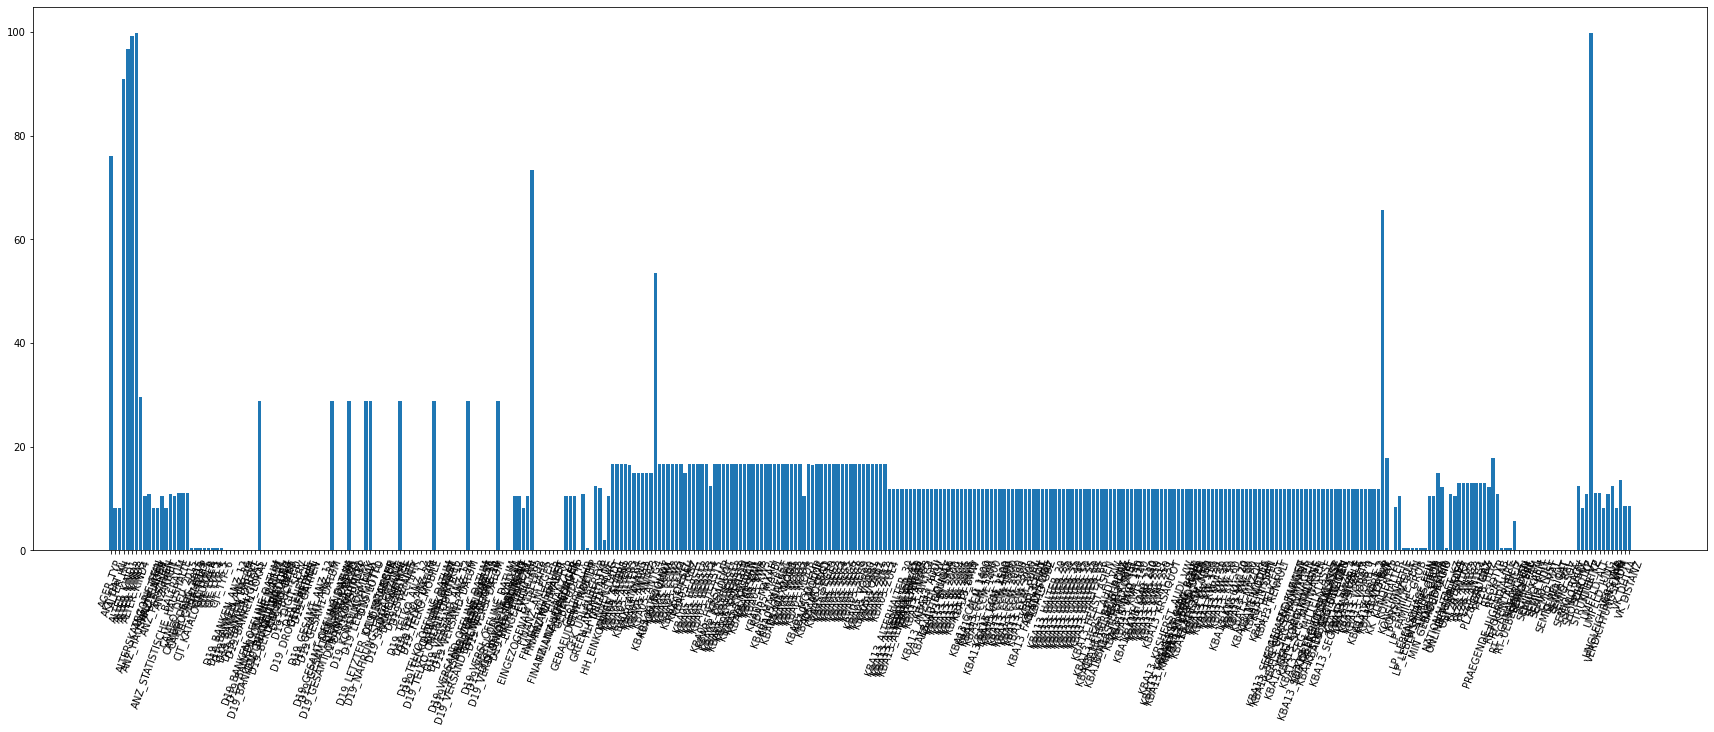

In [24]:
# visualize it
n = 0 # range of columns to plot for manual inspection
m = 358
plt.figure(figsize = (30,10))
plt.bar(demo.columns[n:m], nan_values[n:m])
plt.xticks(rotation = 70);

In [25]:
# removing columns with more than 40% missing data
rm_columns = ["AGER_TYP", "ALTER_KIND1","ALTER_KIND2", "ALTER_KIND3", "ALTER_KIND4", "EXTSEL992", "KK_KUNDENTYP"]
demo.drop(axis = 1, columns = rm_columns, inplace = True)

In [26]:
# checking:
len(demo.columns)

358

## Check for missing data in the rows
To make a decision regarding the cells that still have missing data in them, I will split the dataset in two subsets. One subset will have little missing data and the other one all the rows with missing data. If the distribution of the column values is similar enough I will leave the missing data in. Otherwisen I will only work on the subset of the rows with little missing data.

In [27]:
# histogram of how much data is missing in each row
demo["missing"] = demo.apply(lambda x: (demo.shape[1] - x.count()), axis = 1)

<AxesSubplot:ylabel='Frequency'>

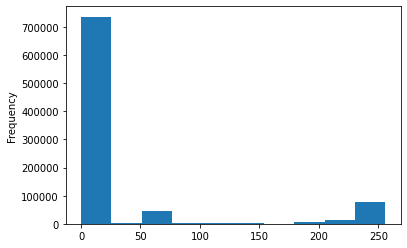

In [28]:
demo["missing"].plot.hist()

In [29]:
# dividing data in two subsets:
demo_full = demo.query("missing < 20")
demo_miss = demo.query("missing >= 0")

In [30]:
# function to compare distribution values of a column
def plot_comparison(column):
    plt.figure(figsize = (15,5))
    plt.subplot(1,2,1)
    sns.countplot(x=demo_full[column], color = "grey")
    plt.xlabel("No missing data")
    plt.title(column)
    plt.subplot(1,2,2)
    sns.countplot(x=demo_miss[column], color = "grey")
    plt.xlabel("Missing data")
    plt.title(column);

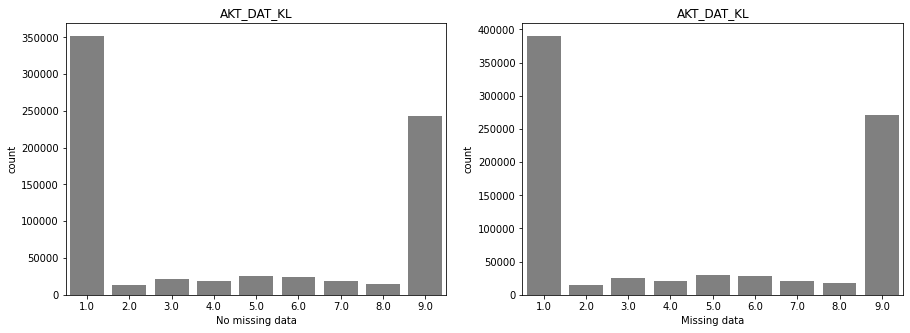

In [31]:
plot_comparison(demo.columns[0])

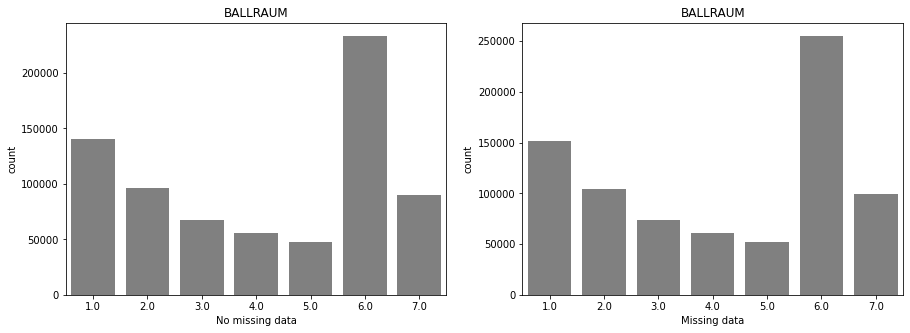

In [32]:
plot_comparison(demo.columns[10])

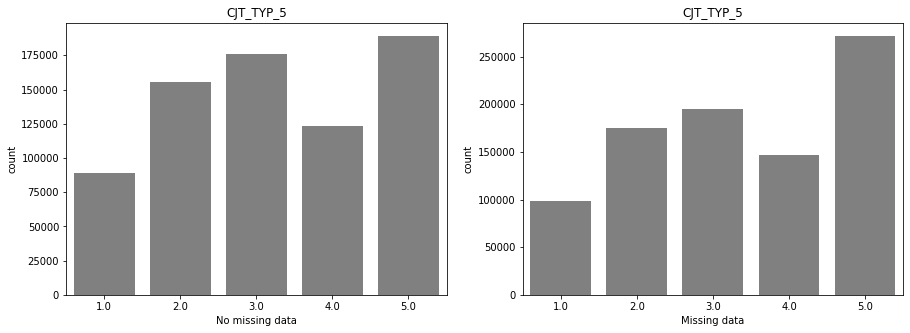

In [33]:
plot_comparison(demo.columns[20])

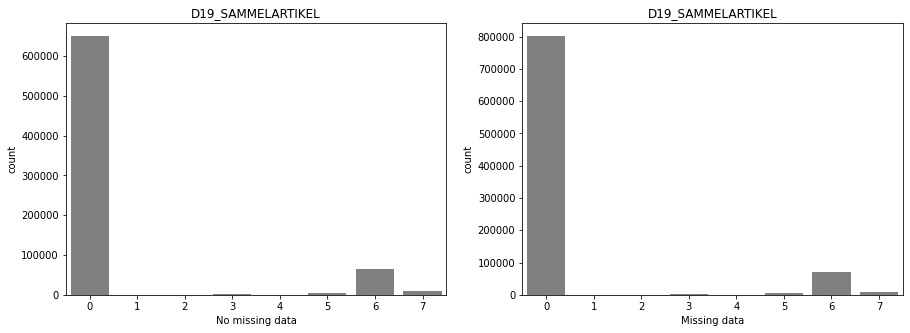

In [34]:
plot_comparison(demo.columns[60])

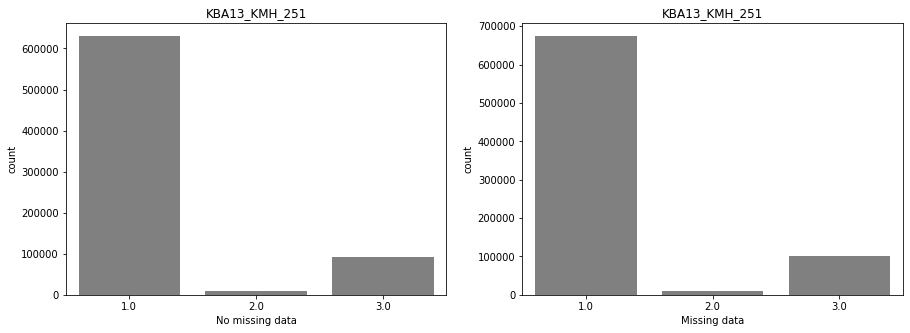

In [35]:
plot_comparison(demo.columns[240])

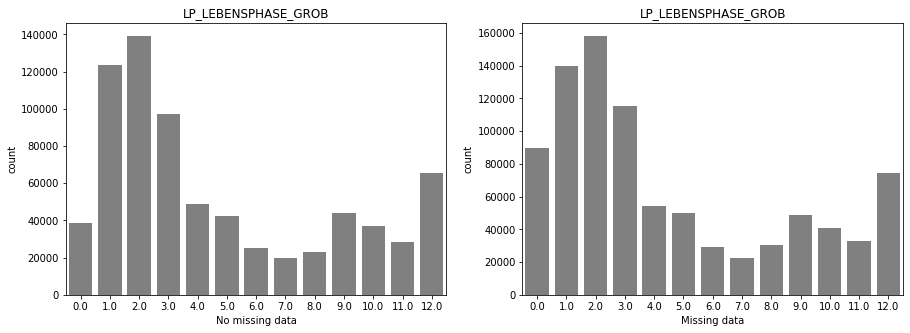

In [36]:
plot_comparison(demo.columns[300])

In [37]:
print(len(demo_full))
print(len(demo_miss))

732136
891221


### Decision:
Some columns like "Lebensphase_grob" or "CJT_typ_5" have very different distributions. Since the dataset with very little missing data still has a lot of rows (751,331) I will discard the subset with missing values.

In [38]:
feat_info.head()

,missing_or_unknown
Attribute,
AGER_TYP,[-1]
ALTERSKATEGORIE_GROB,"[-1, 0]"
ANREDE_KZ,"[-1, 0]"
BALLRAUM,[-1]
BIP_FLAG,[-1]


# Re-encode features
From the inspection of DIAS Attributes - Values it seems that almost all values are of categorical sometimes ordinal nature. After checking for numeric values, I will create dummies for the categorical data

In [39]:
for column in demo_full:
    if demo_full[column].nunique() > 22:
        print(column, demo_full[column].nunique(), demo_full[column].unique()[:3])

ALTERSKATEGORIE_FEIN 26 [21. 17. 13.]
ANZ_HAUSHALTE_AKTIV 284 [11. 10.  1.]
ANZ_PERSONEN 27 [2. 1. 0.]
ANZ_STATISTISCHE_HAUSHALTE 254 [12.  7.  2.]
CAMEO_DEU_2015 45 ['8A' '4C' '2A']
CAMEO_INTL_2015 43 [51.0 24.0 12.0]
D19_LETZTER_KAUF_BRANCHE 35 [nan 'D19_UNBEKANNT' 'D19_SCHUHE']
EINGEFUEGT_AM 2813 ['1992-02-10 00:00:00' '1992-02-12 00:00:00' '1997-04-21 00:00:00']
EINGEZOGENAM_HH_JAHR 37 [2004. 2000. 1998.]
GEBURTSJAHR 116 [1996 1979 1957]
KBA13_ANZAHL_PKW 1261 [963. 712. 596.]
LP_LEBENSPHASE_FEIN 41 [21.  3.  0.]
VERDICHTUNGSRAUM 46 [ 0.  1. 35.]


In [40]:
numeric_values = ["ANZ_HAUSHALTE_AKTIV", "ANZ_HH_TITEL", "ANZ_PERSONEN", "ANZ_TITEL", "KBA13_ANZAHL_PKW"]
drop_cols = ["EINGEFUEGT_AM", "missing"]

In [41]:
demo_full.drop(columns = drop_cols, inplace = True)

/Users/jj/Documents/udacity/venv/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [42]:
# encode all columns except the numeric ones
dummy_cols = [col for col in demo_full.columns if col not in numeric_values]

In [43]:
print(demo_full.shape)
demo_dum = pd.get_dummies(demo_full, columns = dummy_cols, drop_first = True, dummy_na = True)

(732136, 357)


In [44]:
demo_dum.shape

(732136, 2720)

In [45]:
demo_dum.head()

,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,KBA13_ANZAHL_PKW,AKT_DAT_KL_2.0,AKT_DAT_KL_3.0,AKT_DAT_KL_4.0,AKT_DAT_KL_5.0,AKT_DAT_KL_6.0,...,ZABEOTYP_5.0,ZABEOTYP_6.0,ZABEOTYP_nan,ANREDE_KZ_2.0,ANREDE_KZ_nan,ALTERSKATEGORIE_GROB_2.0,ALTERSKATEGORIE_GROB_3.0,ALTERSKATEGORIE_GROB_4.0,ALTERSKATEGORIE_GROB_9.0,ALTERSKATEGORIE_GROB_nan
LNR,,,,,,,,,,,,,,,,,,,,,
910220,11.0,0.0,2.0,0.0,963.0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
910225,10.0,0.0,1.0,0.0,712.0,0,0,0,0,0,...,1,0,0,1,0,0,1,0,0,0
910226,1.0,0.0,0.0,0.0,596.0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
910241,3.0,0.0,4.0,0.0,435.0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
910244,5.0,0.0,1.0,0.0,1300.0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


# Create cleaning function

In [46]:
def clean_data(dataset):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    import sys
    import warnings

    if not sys.warnoptions:
        warnings.simplefilter("ignore")
    df = dataset.copy()
    #load the feature info
    feat_info = pd.read_excel("DIAS Attributes - Values 2017.xlsx", header = 1)
    # set the index
    df.set_index("LNR", inplace = True)
    
    # Get only the rows that show the values for unknown
    feat_info = feat_info.query("Meaning == 'unknown' or Meaning == 'missing'")
    # Drop columns that we don't need for the unknown to nan convert
    feat_info.drop(columns = ["Unnamed: 0", "Description", "Meaning"], inplace = True)
    # set the attribute as the index
    feat_info.set_index("Attribute", inplace = True)
    # convert to list
    feat_info["Value"] = feat_info["Value"].astype(str)
    # Save in a column with different name
    feat_info["missing_or_unknown"] = feat_info["Value"].apply(lambda x: x.split(","))
    # Drop original column
    feat_info.drop(columns = ["Value"], inplace = True)
    
    ## NaN encoding
    # Iterates through the columns of demografics
    for column in df.columns:
        # saves the values as a list which are nan in this colum
        try:
            null_values = feat_info.loc[str(column), "missing_or_unknown"]
        except:
            # some value coding is missing but -1 alway codes for NaN"
            null_values = ["-1"]
        for entry in null_values:
            # Some columns do not have an indicator for null values,
            try:
                if (entry != ""):
                    # replaces every null value with an np.nan in the column
                    df[column] = df[column].replace(int(entry), np.nan)
                else:
                    print("Entry was an empty string: -{}- (should be empty)".format(entry))
            except:
                print("Entry {} is not a number.".format(entry))
                df[column] = df[column].replace(entry, np.nan)
                
    # remove columns with too many missing values
    rm_columns = ["AGER_TYP", "ALTER_KIND1","ALTER_KIND2", "ALTER_KIND3", "ALTER_KIND4", "EXTSEL992", "KK_KUNDENTYP"]
    df.drop(axis = 1, columns = rm_columns, inplace = True)
    
    # count how many values are missing per row
    df["missing"] = df.apply(lambda x: (df.shape[1] - x.count()), axis = 1)
    # keep only rows with less than 0 values missing
    df_full = df.query("missing < 20")
    
    
    ## one-hot encoding
    numeric_values = ["ANZ_HAUSHALTE_AKTIV", "ANZ_HH_TITEL", "ANZ_PERSONEN", "ANZ_TITEL", "KBA13_ANZAHL_PKW","ANZ_KINDER", "ANZ_STATISTISCHE_HAUSHALTE"]
    drop_cols = ["EINGEFUEGT_AM", "missing"]
    df_full.drop(columns = drop_cols, inplace = True)
    # encode all columns except the numeric ones
    dummy_cols = [col for col in df_full.columns if col not in numeric_values]
    df_dum = pd.get_dummies(df_full, columns = dummy_cols, drop_first = True, dummy_na = True)
    df_dum.dropna(inplace = True)
    return df_dum

# Feature transformation
## Numerical feature scaling

In [47]:
# load in the data
demo = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';')

/Users/jj/Documents/udacity/venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [48]:
demo.shape

(891221, 366)

In [49]:
clean_df = clean_data(demo)

In [50]:
clean_df.shape

(728852, 2458)

In [51]:
df = clean_df.copy()

In [52]:
scale_cols = ["ANZ_HAUSHALTE_AKTIV", "ANZ_HH_TITEL", "ANZ_PERSONEN", "ANZ_TITEL", "KBA13_ANZAHL_PKW","ANZ_KINDER", "ANZ_STATISTISCHE_HAUSHALTE"]

In [53]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df[scale_cols] = scaler.fit_transform(df[scale_cols])

In [54]:
df.head(1)

,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,KBA13_ANZAHL_PKW,AKT_DAT_KL_2.0,AKT_DAT_KL_3.0,AKT_DAT_KL_4.0,...,ZABEOTYP_5.0,ZABEOTYP_6.0,ZABEOTYP_nan,ANREDE_KZ_2.0,ANREDE_KZ_nan,ALTERSKATEGORIE_GROB_2.0,ALTERSKATEGORIE_GROB_3.0,ALTERSKATEGORIE_GROB_4.0,ALTERSKATEGORIE_GROB_9.0,ALTERSKATEGORIE_GROB_nan
LNR,,,,,,,,,,,,,,,,,,,,,
910220,0.183515,-0.125631,-0.299203,0.219258,0.331997,-0.060641,1.023528,0,0,0,...,1,0,0,1,0,0,0,0,0,0


## Dimensionality reduction

In [55]:
df.shape

(728852, 2458)

In [56]:
# Apply PCA to the data.
from sklearn.decomposition import PCA
pca = PCA()

In [57]:
#df_pca = pca.fit_transform(df)

In [58]:
"""
# Investigate the variance accounted for by each principal component.
cumm_values = []
former = 0
# variable that makes sure the success print is only printed once
first = True
for idx,value in enumerate(pca.explained_variance_ratio_):
    cumm_values.append(value+former)
    former += value
    if former >= 0.9 and first:
        print("{:.2f} % variance explained with {} components".format(former*100, idx))
        first = False
plt.plot(cumm_values);
"""

'\n# Investigate the variance accounted for by each principal component.\ncumm_values = []\nformer = 0\n# variable that makes sure the success print is only printed once\nfirst = True\nfor idx,value in enumerate(pca.explained_variance_ratio_):\n    cumm_values.append(value+former)\n    former += value\n    if former >= 0.9 and first:\n        print("{:.2f} % variance explained with {} components".format(former*100, idx))\n        first = False\nplt.plot(cumm_values);\n'

In [59]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components = 728)
df_pca = pca.fit_transform(df)

In [60]:
df_pca.shape

(728852, 728)

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

## Clustering to general population

In [61]:
from sklearn.cluster import KMeans


clusters = [2,4,6,8,10,12,14,16,18,20]

# Over a number of different cluster counts...
kmeans_score = []
for idx,n_cluster in enumerate(clusters):
    print("Fitting kmeans with {} clusters".format(n_cluster))
    # run k-means clustering on the data and...
    kmeans = KMeans(n_clusters=n_cluster, random_state=0).fit(df_pca)
    print("Calculating the score...")
    # compute the average within-cluster distances.
    kmeans_score.append(np.abs(kmeans.score(df_pca)))
    
    

# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(clusters,kmeans_score)

In [63]:
# slight elbow at 12 clusters
kmeans = KMeans(n_clusters=12, random_state=0).fit(df_pca)

In [64]:
preds = kmeans.predict(df_pca)
clean_df["cluster"] = preds

## Clustering cutomer data

In [65]:
# load the customer data
customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';')

In [66]:
# There seem to be more columns in the customer data than in the demographics data
customers_red = customers[demo.columns]

In [67]:
# make sure all columns are the same
(demo.columns == customers_red.columns).all()

True

In [68]:
# wrangle and clean the data in the same format
clean_cus = clean_data(customers_red)

In [69]:
# Make sure the same columns exist after the one-hot encoding
# add 0 columns that didn't exist
missing_cols = [column for column in clean_df.columns if column not in clean_cus.columns]
for col in missing_cols:
    clean_cus[col]=0
before_drop = len(clean_cus.columns)
clean_cus = clean_cus[clean_df.columns]

if "cluster" in clean_cus.columns:
    clean_cus.drop(columns = ["cluster"], inplace = True)
print("{} columns added and {} dropped. Try to minimize amount dropped.".format(len(missing_cols), before_drop-len(clean_cus.columns)))

20 columns added and 3 dropped. Try to minimize amount dropped.


In [70]:
cus_df = clean_cus.copy()

In [71]:
cus_df[scale_cols] = scaler.transform(cus_df[scale_cols])

In [72]:
cus_pca = pca.transform(cus_df)

In [73]:
len(clean_cus.columns) 

2458

In [74]:
len(clean_df.columns)

2459

In [75]:
cus_preds = kmeans.predict(cus_pca)

In [76]:
len(cus_preds)

129195

In [77]:
cus_df["cluster"] = cus_preds

## Compare customer data to demographics data

<AxesSubplot:xlabel='cluster', ylabel='count'>

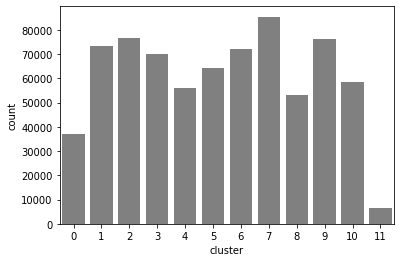

In [78]:
sns.countplot(x = "cluster",data = clean_df, color = "grey" )

<AxesSubplot:xlabel='cluster', ylabel='count'>

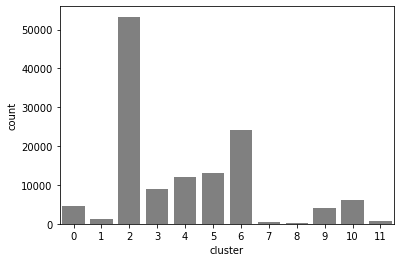

In [79]:
sns.countplot(x = "cluster",data = cus_df, color = "grey" )

### Insights
In contrast to the general population of Germany the customers are mainly in cluster 5. A medium amount is in cluster 10 and low amounts in 3, 6 and 9. For aquiring new customers it is recommended to focus on these clusters.
## Cluster meaning
After clustering on top of dimension reduced data it can be hard to know which features of the original dataset are included. I will investigate in the following

In [80]:
# Inversing the pca of the cluster centers
cluster_centers = kmeans.cluster_centers_
cc_ss = pca.inverse_transform(cluster_centers)

In [81]:
cc_ss.shape

(12, 2458)

In [82]:
# label the columns with the cus_df names except the last one which is "clusters"
cc_org = pd.DataFrame(cc_ss, columns = cus_df.columns[:-1])

#### Cluster 5

In [83]:
# top 10 positive influential features
cc_org.iloc[5:6,:].T.sort_values(by = 5, ascending = False)[:10]

,5
D19_VERSI_ONLINE_DATUM_10.0,0.997711
TITEL_KZ_nan,0.996785
D19_BANKEN_OFFLINE_DATUM_10.0,0.993473
D19_TELKO_ONLINE_DATUM_10.0,0.992095
D19_VERSI_OFFLINE_DATUM_10.0,0.991973
DSL_FLAG_1.0,0.990334
KOMBIALTER_4.0,0.965152
D19_TELKO_OFFLINE_DATUM_10.0,0.960826
D19_BANKEN_ONLINE_DATUM_10.0,0.919695
D19_BANKEN_DATUM_10.0,0.884349


In [84]:
# top 10 negative influential features
cc_org.iloc[5:6,:].T.sort_values(by = 5, ascending = False)[-10:]

,5
LP_LEBENSPHASE_FEIN_4.0,-0.004584
LP_LEBENSPHASE_FEIN_39.0,-0.004709
PRAEGENDE_JUGENDJAHRE_11.0,-0.006632
LP_LEBENSPHASE_FEIN_3.0,-0.007075
LP_LEBENSPHASE_FEIN_37.0,-0.007681
LP_LEBENSPHASE_FEIN_10.0,-0.007697
LP_LEBENSPHASE_FEIN_11.0,-0.012559
ANZ_KINDER,-0.283728
ANZ_PERSONEN,-0.352243
KBA13_ANZAHL_PKW,-0.361840


#### Cluster 10

In [85]:
# top 10 positive influential features
cc_org.iloc[10:11,:].T.sort_values(by = 10, ascending = False)[:10]

,10
TITEL_KZ_nan,0.998812
D19_VERSI_ONLINE_DATUM_10.0,0.991147
D19_TELKO_ONLINE_DATUM_10.0,0.985633
D19_BANKEN_OFFLINE_DATUM_10.0,0.964596
D19_VERSI_OFFLINE_DATUM_10.0,0.948364
DSL_FLAG_1.0,0.936330
KBA13_KRSSEG_KLEIN_2.0,0.907778
D19_TELKO_OFFLINE_DATUM_10.0,0.881116
KBA05_KRSOBER_2.0,0.873770
KBA05_KRSVAN_2.0,0.830548


In [86]:
# top 10 negative influential features
cc_org.iloc[10:11,:].T.sort_values(by = 10, ascending = False)[-10:]

,10
VERDICHTUNGSRAUM_5.0,-0.003824
VERDICHTUNGSRAUM_3.0,-0.005218
LP_LEBENSPHASE_FEIN_6.0,-0.005917
VERDICHTUNGSRAUM_4.0,-0.007083
ANZ_TITEL,-0.030670
ANZ_HH_TITEL,-0.111351
ANZ_KINDER,-0.121248
ANZ_STATISTISCHE_HAUSHALTE,-0.381598
ANZ_HAUSHALTE_AKTIV,-0.388151
KBA13_ANZAHL_PKW,-0.663884


## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [87]:
mailout_train = pd.read_csv('data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

In [88]:
m_df = mailout_train.copy()

In [89]:
m_df_clean = clean_data(m_df)

In [90]:
m_df_clean.head(1)

,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,KBA13_ANZAHL_PKW,AKT_DAT_KL_2.0,AKT_DAT_KL_3.0,AKT_DAT_KL_4.0,...,ZABEOTYP_nan,RESPONSE_1.0,RESPONSE_nan,ANREDE_KZ_2.0,ANREDE_KZ_nan,ALTERSKATEGORIE_GROB_2.0,ALTERSKATEGORIE_GROB_3.0,ALTERSKATEGORIE_GROB_4.0,ALTERSKATEGORIE_GROB_9.0,ALTERSKATEGORIE_GROB_nan
LNR,,,,,,,,,,,,,,,,,,,,,
1763,15.0,0.0,0.0,1.0,13.0,0.0,390.0,0,0,0,...,0,0,0,1,0,0,0,1,0,0


In [91]:
# Cleaning functions messes up the response value a bit
m_df_clean.rename(columns = {"RESPONSE_1.0": "RESPONSE"}, inplace = True)
m_df_clean.drop(columns = ["RESPONSE_nan"], inplace = True)

# Save the outcome in a variable and drop the column before the dimension reduction
response = m_df_clean["RESPONSE"]
m_df_clean.drop(columns = ["RESPONSE"], inplace = True)

# Make sure the same columns exist after the one-hot encoding
# add 0 columns that didn't exist
missing_cols = [column for column in clean_df.columns if column not in m_df_clean.columns]
for col in missing_cols:
    m_df_clean[col]=0
before_drop = len(m_df_clean.columns)
m_df_clean = m_df_clean[clean_df.columns]

if "cluster" in m_df_clean.columns:
    m_df_clean.drop(columns = ["cluster"], inplace = True)
print("{} columns added and {} dropped. Try to minimize amount dropped.".format(len(missing_cols), before_drop-len(m_df_clean.columns)))

32 columns added and 1 dropped. Try to minimize amount dropped.


#### Now the train dataframe has the same columns as the pca expects.

In [92]:
# Perform PCA on the train data
m_df_pca = pca.transform(m_df_clean)

m_df_pca = pd.DataFrame(m_df_pca)

m_df_pca["cluster"] = kmeans.predict(m_df_pca)

In [93]:
# this is a bit surprising. Our clustering resulted that the existing Arvato customers are mainly in cluster 5. 
# However in the dataset the people targeted almost all fall in cluster 6. Now maybe our clustering wasn't very good or the wrong people were targeted for the campaign

<AxesSubplot:>

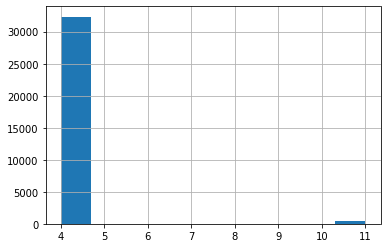

In [94]:
m_df_pca.cluster.hist()

In [95]:
# since all customers are in the same cluster the column is dropped again
m_df_pca.drop(columns = ["cluster"], inplace = True )

In [96]:
X = m_df_pca
y = response

In [97]:
# splitting for training and testing
X_train, X_test, y_train, y_split = train_test_split(X, y, test_size=0.33, random_state=42)

## Random Forest Regressor

In [100]:
# set up model
reg = RandomForestRegressor()

# set up parameters for grid search
parameters = {'n_estimators':[100,150], 
              'max_depth':[20,30]}
reg = GridSearchCV(rfr, parameters, verbose = 10, scoring = "roc_auc", cv = 5)
reg.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.7s remaining:    0.0s


building tree 2 of 100


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   31.7s remaining:    0.0s


building tree 3 of 100


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   47.7s remaining:    0.0s


building tree 4 of 100


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.0min remaining:    0.0s


building tree 5 of 100


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.3min remaining:    0.0s


building tree 6 of 100


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.6min remaining:    0.0s


building tree 7 of 100


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.8min remaining:    0.0s


building tree 8 of 100


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  2.1min remaining:    0.0s


building tree 9 of 100


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  2.4min remaining:    0.0s


building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 28.9min finished


RandomForestRegressor(max_depth=20, verbose=10)

In [101]:
preds = reg.predict(X_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished


#### Judging the results
Accuracy would not be a very good score, since we have only few customers that answered and a lot that didn't. (Auccuracy would always be high)
The goal is to get as many responses as possible. Therefore we want to correctly predict all customers that respond (True positives) and don't mind if we get a few false positives. We want to minimize false negatives.
Recall is therefore the score best to judge the model.

In [ ]:
#recall_score(y_train, preds)

In [102]:
roc_auc_score(y_train, preds)

0.9990691013247404

In [ ]:
#reg.best_estimator_.get_params()

## Support Vector Machine

In [157]:
# set up model
svc = SVR()

# set up parameters for grid search
parameters = {'C':[0.1, 0.5, 1.5, 5], 
              'degree':[3, 4, 5],
              'kernel': ["poly", "rbf"]}
reg_svc = GridSearchCV(svc, parameters, verbose = 10, scoring = "roc_auc", cv = 5)
reg_svc.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] C=0.1, degree=3, kernel=poly ....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........ C=0.1, degree=3, kernel=poly, score=0.567, total=  16.4s
[CV] C=0.1, degree=3, kernel=poly ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.4s remaining:    0.0s


[CV] ........ C=0.1, degree=3, kernel=poly, score=0.618, total=  17.1s
[CV] C=0.1, degree=3, kernel=poly ....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   33.5s remaining:    0.0s


[CV] ........ C=0.1, degree=3, kernel=poly, score=0.535, total=  16.1s
[CV] C=0.1, degree=3, kernel=poly ....................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   49.6s remaining:    0.0s


[CV] ........ C=0.1, degree=3, kernel=poly, score=0.545, total=  18.4s
[CV] C=0.1, degree=3, kernel=poly ....................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.1min remaining:    0.0s


[CV] ........ C=0.1, degree=3, kernel=poly, score=0.578, total=  18.2s
[CV] C=0.1, degree=3, kernel=rbf .....................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.4min remaining:    0.0s


[CV] ......... C=0.1, degree=3, kernel=rbf, score=0.563, total=  11.5s
[CV] C=0.1, degree=3, kernel=rbf .....................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.6min remaining:    0.0s


[CV] ......... C=0.1, degree=3, kernel=rbf, score=0.550, total=  12.5s
[CV] C=0.1, degree=3, kernel=rbf .....................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.8min remaining:    0.0s


[CV] ......... C=0.1, degree=3, kernel=rbf, score=0.586, total=  12.8s
[CV] C=0.1, degree=3, kernel=rbf .....................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  2.1min remaining:    0.0s


[CV] ......... C=0.1, degree=3, kernel=rbf, score=0.508, total=  11.5s
[CV] C=0.1, degree=3, kernel=rbf .....................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  2.2min remaining:    0.0s


[CV] ......... C=0.1, degree=3, kernel=rbf, score=0.546, total=  12.6s
[CV] C=0.1, degree=4, kernel=poly ....................................
[CV] ........ C=0.1, degree=4, kernel=poly, score=0.563, total=  32.4s
[CV] C=0.1, degree=4, kernel=poly ....................................
[CV] ........ C=0.1, degree=4, kernel=poly, score=0.581, total=  30.8s
[CV] C=0.1, degree=4, kernel=poly ....................................
[CV] ........ C=0.1, degree=4, kernel=poly, score=0.456, total=  28.9s
[CV] C=0.1, degree=4, kernel=poly ....................................
[CV] ........ C=0.1, degree=4, kernel=poly, score=0.532, total=  31.8s
[CV] C=0.1, degree=4, kernel=poly ....................................
[CV] ........ C=0.1, degree=4, kernel=poly, score=0.576, total=  27.7s
[CV] C=0.1, degree=4, kernel=rbf .....................................
[CV] ......... C=0.1, degree=4, kernel=rbf, score=0.563, total=  11.5s
[CV] C=0.1, degree=4, kernel=rbf .....................................
[CV] .

[CV] ......... C=1.5, degree=3, kernel=rbf, score=0.600, total=  35.6s
[CV] C=1.5, degree=3, kernel=rbf .....................................
[CV] ......... C=1.5, degree=3, kernel=rbf, score=0.603, total=  32.4s
[CV] C=1.5, degree=3, kernel=rbf .....................................
[CV] ......... C=1.5, degree=3, kernel=rbf, score=0.557, total=  34.1s
[CV] C=1.5, degree=4, kernel=poly ....................................
[CV] ........ C=1.5, degree=4, kernel=poly, score=0.560, total=  41.4s
[CV] C=1.5, degree=4, kernel=poly ....................................
[CV] ........ C=1.5, degree=4, kernel=poly, score=0.555, total=  42.2s
[CV] C=1.5, degree=4, kernel=poly ....................................
[CV] ........ C=1.5, degree=4, kernel=poly, score=0.474, total=  40.6s
[CV] C=1.5, degree=4, kernel=poly ....................................
[CV] ........ C=1.5, degree=4, kernel=poly, score=0.527, total=  43.5s
[CV] C=1.5, degree=4, kernel=poly ....................................
[CV] .

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 76.8min finished


GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': [0.1, 0.5, 1.5, 5], 'degree': [3, 4, 5],
                         'kernel': ['poly', 'rbf']},
             scoring='roc_auc', verbose=10)

In [158]:
svc_preds = reg_svc.predict(X_train)

In [159]:
roc_auc_score(y_train, svc_preds)

0.9471201383012513

In [210]:
reg_svc.best_estimator_.get_params()

{'C': 5,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.1,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [115]:
mailout_test = pd.read_csv('data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

In [169]:
mailout_test.head(1)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4


In [116]:
test_clean = clean_data(mailout_test)

In [118]:
# Make sure the same columns exist after the one-hot encoding
# add 0 columns that didn't exist
missing_cols = [column for column in clean_df.columns if column not in test_clean.columns]
for col in missing_cols:
    test_clean[col]=0
before_drop = len(test_clean.columns)
test_clean = test_clean[clean_df.columns]

if "cluster" in test_clean.columns:
    test_clean.drop(columns = ["cluster"], inplace = True)
print("{} columns added and {} dropped. Try to minimize amount dropped.".format(len(missing_cols), before_drop-len(m_df_clean.columns)))

37 columns added and 2 dropped. Try to minimize amount dropped.


In [121]:
# Perform PCA on the train data
test_pca = pca.transform(test_clean)

#test_pca = pd.DataFrame(test_pca)

#test_pca["cluster"] = kmeans.predict(test_pca)

In [160]:
test_preds_svc = reg_svc.predict(test_pca)

In [161]:
results = pd.DataFrame(data= {"Index": test_clean.index, "values":test_preds_svc})

In [162]:
results["values"].value_counts()

0.100204    1
0.099474    1
0.100137    1
0.099732    1
0.099643    1
           ..
0.099556    1
0.099566    1
0.099687    1
0.099800    1
0.099925    1
Name: values, Length: 32782, dtype: int64

In [165]:
results.to_csv("results.csv", index = False)

In [195]:
merger = results.merge(mailout_test, left_on = "Index", right_on = "LNR", how = "right" )

In [196]:
merger = merger.iloc[:, :3]

In [197]:
for idx, value in enumerate(merger["Index"]):
    if value != value:
        merger.iloc[idx, 1] = 0
        merger.iloc[idx, 0] = merger.iloc[idx, 2]

In [198]:
merger["Index"] = merger["Index"].astype(int)

In [199]:
merger.drop(columns = ["LNR"], inplace = True)

In [207]:
merger.rename(columns = {"Index": "LNR", "values": "RESPONSE"}, inplace = True)

In [208]:
merger.to_csv("results.csv", index = False)

In [209]:
merger

,LNR,RESPONSE
0,1754,0.099907
1,1770,0.098944
2,1465,0.099711
3,1470,0.099859
4,1478,0.098783
...,...,...
42828,67615,0.000000
42829,67938,0.099925
42830,67942,0.099701
42831,67949,0.100166


In [150]:
test_preds_reg = reg.predict(test_pca)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished


In [151]:
results_reg = pd.DataFrame(data= {"Index": test_clean.index, "values":test_preds_reg})

In [155]:
results_reg["values"].value_counts()

0.016860    1
0.011251    1
0.007249    1
0.025679    1
0.006186    1
           ..
0.010210    1
0.007692    1
0.006698    1
0.008153    1
0.006947    1
Name: values, Length: 32782, dtype: int64